In [86]:
import pandas as pd
import numpy as np
import pmdarima as pm
import os

os.chdir('D:/UMich/IOE541/') 


# STEP 1: Load necessary data
df_sale = pd.read_csv('D:/UMich/IOE541/Data/kaggle/input/sales_train_validation.csv')
df_calendar = pd.read_csv('D:/UMich/IOE541/Data/kaggle/input/calendar.csv')

 # STEP 2: Extract date columns and map to real dates
date_columns = df_sale.columns[df_sale.columns.str.contains("d_")]
dates_s = [pd.to_datetime(df_calendar.loc[df_calendar['d'] == str_date, 'date'].values[0]) for str_date in date_columns]

# # STEP 3: Filter the row for target product
product_id = 'FOODS_3_819_WI_3_validation'
row = df_sale[df_sale['id'] == product_id].iloc[0]

In [94]:
# STEP 4: Create time series DataFrame
ts_df = pd.DataFrame({
    'ds': dates_s,
    'y': row[date_columns].astype(float).values  # convert sales to numeric
})

print(ts_df)


             ds     y
0    2011-01-29  14.0
1    2011-01-30  11.0
2    2011-01-31   5.0
3    2011-02-01   6.0
4    2011-02-02   5.0
...         ...   ...
1908 2016-04-20   1.0
1909 2016-04-21   3.0
1910 2016-04-22   1.0
1911 2016-04-23   0.0
1912 2016-04-24   2.0

[1913 rows x 2 columns]


In [96]:
# Check number of missing values in each column
print("Missing values per column:")
print(ts_df.isna().sum())
# ts_df = ts_df.dropna(subset=['y'])  # drops rows where 'y' is NaN
# del df_sale
# ts_df.to_csv("ts_df.csv", index=False)
# print("ts_df saved to ts_df.csv")

Missing values per column:
ds    0
y     0
dtype: int64


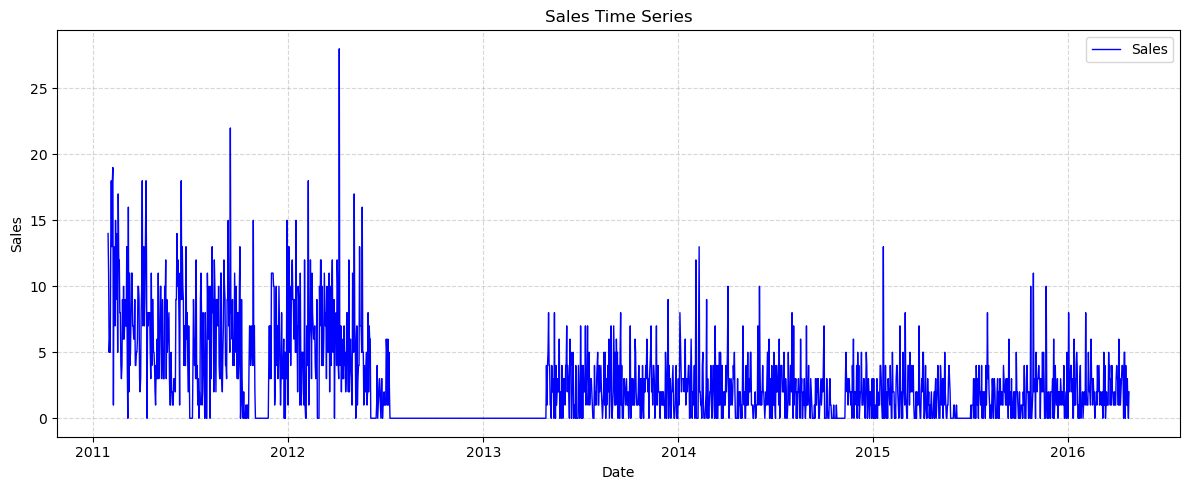

In [98]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(ts_df['ds'], ts_df['y'], label='Sales', color='blue', linewidth=1)

plt.title('Sales Time Series')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.legend()
plt.show()


Although this product does not have missing values, it contains lots of zeros in the raw dataset. We may consider using another product later.

In [70]:
print(ts_df)

             ds     y
0    2011-01-29  14.0
1    2011-01-30  11.0
2    2011-01-31   5.0
3    2011-02-01   6.0
4    2011-02-02   5.0
...         ...   ...
1908 2016-04-20   1.0
1909 2016-04-21   3.0
1910 2016-04-22   1.0
1911 2016-04-23   0.0
1912 2016-04-24   2.0

[1913 rows x 2 columns]


In [100]:
import pandas as pd
import numpy as np
import pmdarima as pm

# Configuration
R = 7  # review period
L = 3   # forecast lag
T = len(date_columns)  # total number of days
start_idx = T - 393
end_idx = T - 1

# === STEP 1: Build review points ===
review_indices = list(range(end_idx, start_idx - 1, -R))
review_indices = sorted(review_indices)  # ascending time order
print(review_indices)


[1520, 1527, 1534, 1541, 1548, 1555, 1562, 1569, 1576, 1583, 1590, 1597, 1604, 1611, 1618, 1625, 1632, 1639, 1646, 1653, 1660, 1667, 1674, 1681, 1688, 1695, 1702, 1709, 1716, 1723, 1730, 1737, 1744, 1751, 1758, 1765, 1772, 1779, 1786, 1793, 1800, 1807, 1814, 1821, 1828, 1835, 1842, 1849, 1856, 1863, 1870, 1877, 1884, 1891, 1898, 1905, 1912]


Above is review indices, review date should be review index +1

In [51]:
# === STEP 2: Rolling ARIMA with growing window ===
forecasts = []  # to collect results

initial_train_end = start_idx  # index of d_T-393

for review_idx in review_indices:
    # Expand training window: up to review_idx
    train_series = ts_df['y'].iloc[:review_idx + 1].dropna()

    # Fit ARIMA
    try:
        model = pm.auto_arima(train_series, seasonal=True, m=7)
        preds = model.predict(n_periods=R + L)
    except Exception as e:
        print(f"ARIMA failed at review d_{review_idx + 1}: {e}")
        preds = [np.nan] * (R + L)

    # Store forecast results
    forecasts.append({
        'review_index': review_idx,
        'review_day': date_columns[review_idx],
        'forecast_days': [f'F{i+1}' for i in range(R + L)],
        'forecast': preds
    })

In [90]:
print(forecasts)

[{'review_index': 1520, 'review_day': 'd_1521', 'forecast_days': ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10'], 'forecast': 1521    2.249051
1522    2.227876
1523    2.209599
1524    2.193824
1525    2.180208
1526    2.168456
1527    2.158313
1528    2.149558
1529    2.142001
1530    2.135479
dtype: float64}, {'review_index': 1527, 'review_day': 'd_1528', 'forecast_days': ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10'], 'forecast': 1528    2.881913
1529    2.805268
1530    2.739161
1531    2.682144
1532    2.632967
1533    2.590551
1534    2.553967
1535    2.522414
1536    2.495199
1537    2.471726
dtype: float64}, {'review_index': 1534, 'review_day': 'd_1535', 'forecast_days': ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10'], 'forecast': 1535    1.356907
1536    1.411689
1537    1.458958
1538    1.499745
1539    1.534938
1540    1.565304
1541    1.591506
1542    1.614114
1543    1.633621
1544    1.650454
dtype: float64}, {'review_index': 1541

In [97]:
print(forecasts)

# Function to create increasing forecast index per group
def assign_forecast_index(group):
    start = group['review_index'].iloc[0] + 1
    group['forecast_index'] = list(range(start, start + len(group)))
    return group

# Apply the function to each group of the same review_index
df = df.groupby('review_index', group_keys=False).apply(assign_forecast_index)

# Optionally, drop or rename columns
# df.drop(columns='review_index', inplace=True)  # if you no longer need it
# df.rename(columns={'forecast_index': 'review_index'}, inplace=True)

# Save back to CSV
df.to_csv("rolling_forecasts_updated.csv", index=False)

print("✅ Forecast indices updated and saved to 'rolling_forecasts_updated.csv'")

KeyError: 0

In [ ]:

# === STEP 3: Flatten results to long format ===
all_rows = []

for f in forecasts:
    for i in range(R + L):
        all_rows.append({
            'review_day_index': f['review_index'],
            'review_day_code': f['review_day'],
            'horizon': f'F{i+1}',
            'forecast': f['forecast'][i]
        })

forecast_df = pd.DataFrame(all_rows)

# Optional: convert day code to calendar date
forecast_df['review_date'] = forecast_df['review_day_code'].map(
    dict(zip(df_calendar['d'], df_calendar['date']))
)

# Display or save
print(forecast_df.head())
# forecast_df.to_csv("rolling_forecast_by_review_day.csv", index=False)
